# Code for Exercise 3. {-}

For this problem, I am using the dynamic programming template created by Jason DeBacker.

First let's import the relevant modules:

In [20]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Here, we set our parameters equal to those specified in the problem:

In [21]:
gamma = 0.5 # CRRA coefficient
beta = 0.96 # discount factor
delta = 0.05 # depreciation rate
alpha = 0.4 # curvature of production function
sigma_v = 0.2 # SD of productivity shocks
rho = 0.8 # constant for the serial correlation

We now set up our state space grid:

In [22]:
'''
------------------------------------------------------------------------
Create Grid for State Space    
------------------------------------------------------------------------
lb_k      = scalar, lower bound of capital grid
ub_k      = scalar, upper bound of capital grid 
size_k    = integer, number of grid points in capital state space
k_grid    = vector, size_k x 1 vector of capital grid points 
------------------------------------------------------------------------
'''
lb_k = .5
ub_k = 10
size_k = 200  # Number of grid points
k_grid = np.linspace(lb_k, ub_k, size_k)

Next, we construct an array $\mathtt{Z}$ by iterating an $\mathrm{AR}(1)$ process of stochastic shocks $\mathtt{size}\_\mathtt{k}$ times. And, we define some regularity conditions, and set the CRRA utility function based off the consumption we found.

In [23]:
'''
------------------------------------------------------------------------
Create grid of current utility values    
------------------------------------------------------------------------
C        = matrix, current consumption
I        = matrix, current investment
Z        = matrix, productivity shocks
U        = matrix, current period utility value for all possible
           choices of k and k' (rows are k, columns k')
------------------------------------------------------------------------
'''
C = np.zeros((size_k, size_k)) 
Y = np.zeros((size_k, size_k))
I = np.zeros((size_k, size_k))
Z = [0.1]

for i in range(size_k):
    Z.append(np.exp(rho * np.log(Z[i]) + np.random.normal(0,sigma_v)))
    
Z=np.array(Z)

print(Z)

for i in range(size_k): # loop over k
    for j in range(size_k): # loop over k'
        Y[i,j] = Z[i] * k_grid[i] ** alpha # production function = stoch shock * capital ^ alpha
        I[i,j] = k_grid[j] - (1-delta) * k_grid[i] # investment, determined by the k'=(1-delta)k+i law of motion
        C[i, j] = Y[i,j] - I[i,j] # resource constraint
        
# replace 0 and negative consumption with a tiny value 
# This is a way to impose non-negativity on cons
C[C<=0] = 1e-15
I[I<=0] = 1e-15
if gamma == 1:
    U = np.log(C)
else:
    U = (C ** (1-gamma)) / (1-gamma)
U[C<0] = -1e10

[0.1        0.16985324 0.13679666 0.21298965 0.28636382 0.49574118
 0.61502425 0.56781049 0.54970526 0.78633673 0.94826106 1.19114137
 1.23625805 1.24788345 1.44567458 1.20544063 0.96192802 1.14327621
 1.02664832 1.03023454 0.82620914 1.18951098 1.17272709 1.38074157
 1.49786175 1.28155941 1.36401833 1.43070268 1.31685919 1.61970971
 1.55180698 2.15264805 2.0981616  1.84442644 1.81937936 1.20976628
 1.53417086 1.0488133  1.24293448 1.04034409 0.90232281 0.74467291
 0.9518998  0.89443857 1.26689588 1.27676605 1.1055865  1.19091865
 1.25873721 2.19209308 2.21980366 2.15353917 1.62389491 1.80270181
 1.68507414 1.45788849 1.00114093 0.55053844 0.56707766 0.66895343
 0.79837907 0.62302573 0.66428692 0.80356333 0.82712929 0.80879731
 0.89011573 1.15578627 0.83555796 0.85857373 1.01508183 0.88638704
 1.49730572 1.26122016 1.00467495 1.04148602 0.89687673 1.09277206
 0.89631673 0.6339384  0.66332717 0.78362448 0.56516493 0.54928781
 0.60588885 0.73269247 0.78156763 1.11760161 0.92487396 0.6233

Now, this next step is virtually the same as we covered in class, where I apply a Bellman equation $V_{T+1} = u(c) + V_{T}$ looped over multiple iterations, recalculation the value function many times and corresponding policy functions.

In [24]:
'''
------------------------------------------------------------------------
Value Function Iteration    
------------------------------------------------------------------------
VFtol     = scalar, tolerance required for value function to converge
VFdist    = scalar, distance between last two value functions
VFmaxiter = integer, maximum number of iterations for value function
V         = vector, the value functions at each iteration
Vmat      = matrix, the value for each possible combination of k and k'
Vstore    = matrix, stores V at each iteration 
VFiter    = integer, current iteration number
TV        = vector, the value function after applying the Bellman operator
PF        = vector, indicies of choices of k' for all k 
VF        = vector, the "true" value function
------------------------------------------------------------------------
'''
VFtol = 1e-8 
VFdist = 5.0 
VFmaxiter = 3000 
V = np.zeros(size_k) # initial guess at value function
Vmat = np.zeros((size_k, size_k)) # initialize Vmat matrix
Vstore = np.zeros((size_k, VFmaxiter)) #initialize Vstore array
VFiter = 1 
while VFdist > VFtol and VFiter < VFmaxiter:  
    for i in range(size_k): # loop over k
        for j in range(size_k): # loop over k'
            Vmat[i, j] = U[i, j] + beta * V[j] 
      
    Vstore[:, VFiter] = V.reshape(size_k,) # store value function at each iteration for graphing later
    TV = Vmat.max(1) # apply max operator to Vmat (to get V(k))
    PF = np.argmax(Vmat, axis=1)
    VFdist = (np.absolute(V - TV)).max()  # check distance
    V = TV
    VFiter += 1 
    


if VFiter < VFmaxiter:
    print('Value function converged after this many iterations:', VFiter)
else:
    print('Value function did not converge')            


VF = V # solution to the functional equation

Value function converged after this many iterations: 487


There were $\mathtt{489}$ iterations.

This next part involves using the formula for the choice of consumption based off capital, organized in the order of the $\mathtt{PF}$-selected values. I used the formula
$$
\mathtt{optC} = \mathtt{Z}_{\mathtt{PF}} \cdot \mathtt{k}\_\mathtt{grid} ^ \mathtt{alpha} - \left( \mathtt{optK} - (1-\mathtt{delta}) \cdot \mathtt{k}\_\mathtt{grid} \right),
$$
i.e.,
$$
c=z\cdot k^\alpha - (k^{\prime} - (1-\delta)\cdot k).
$$

In [25]:
'''
------------------------------------------------------------------------
Find consumption and savings policy functions   
------------------------------------------------------------------------
optK  = vector, the optimal choice of k' for each k
optC  = vector, the optimal choice of c' for each c
------------------------------------------------------------------------
'''
optK = k_grid[PF] # tomorrow's optimal capital size (savings function)
optC = Z[PF] * k_grid ** alpha - (optK - (1-delta) * k_grid) # optimal consumption, get consumption through the transition eqn

Plotting the $\bf{value}$ $\bf{function}$, we have:

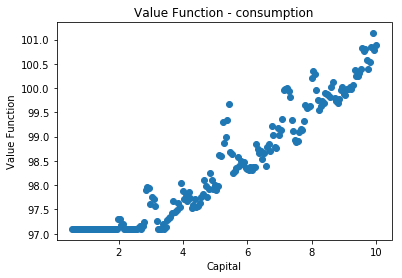

In [26]:
# Plot value function 
plt.figure()
# plt.plot(wvec, VF)
plt.scatter(k_grid[1:], VF[1:])
plt.xlabel('Capital')
plt.ylabel('Value Function')
plt.title('Value Function - consumption')
plt.show()

Now we plot the $\bf{policy}$ $\bf{function}$ for the choice of consumption:

<Figure size 432x288 with 0 Axes>

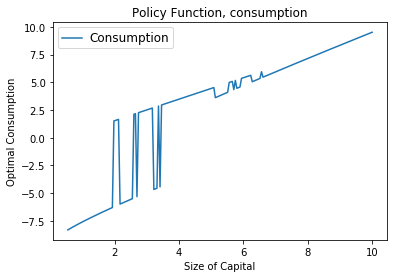

In [27]:
#Plot optimal consumption rule as a function of capital size
plt.figure()
fig, ax = plt.subplots()
ax.plot(k_grid[1:], optC[1:], label='Consumption')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper left', shadow=False)
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Capital')
plt.ylabel('Optimal Consumption')
plt.title('Policy Function, consumption')
plt.show()

Finally, we plot the $\bf{policy}$ $\bf{function}$ for the choice of capital next period:

<Figure size 432x288 with 0 Axes>

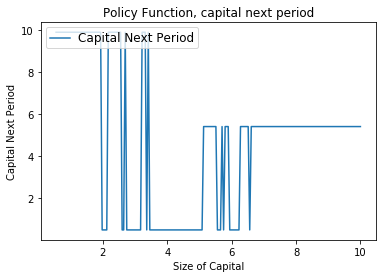

In [28]:
#Plot optimal consumption rule as a function of capital size
plt.figure()
fig, ax = plt.subplots()
ax.plot(k_grid[1:], optK[1:], label='Capital Next Period')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper left', shadow=False)
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Capital')
plt.ylabel('Capital Next Period')
plt.title('Policy Function, capital next period')
plt.show()

Let us now repeat this process for another set of values of the productivity shock $v$. Here we will choose $0.3$.

In [29]:
'''
------------------------------------------------------------------------
Create grid of current utility values    
------------------------------------------------------------------------
C        = matrix, current consumption
I        = matrix, current investment
Z        = matrix, productivity shocks
U        = matrix, current period utility value for all possible
           choices of k and k' (rows are k, columns k')
------------------------------------------------------------------------
'''
C = np.zeros((size_k, size_k)) 
Y = np.zeros((size_k, size_k))
I = np.zeros((size_k, size_k))
Z = [0.3]

for i in range(size_k):
    Z.append(np.exp(rho * np.log(Z[i]) + np.random.normal(0,sigma_v)))
    
Z=np.array(Z)

print(Z)

for i in range(size_k): # loop over k
    for j in range(size_k): # loop over k'
        Y[i,j] = Z[i] * k_grid[i] ** alpha # production function = stoch shock * capital ^ alpha
        I[i,j] = k_grid[j] - (1-delta) * k_grid[i] # investment, determined by the k'=(1-delta)k+i law of motion
        C[i, j] = Y[i,j] - I[i,j] # resource constraint
        
# replace 0 and negative consumption with a tiny value 
# This is a way to impose non-negativity on cons
C[C<=0] = 1e-15
I[I<=0] = 1e-15
if gamma == 1:
    U = np.log(C)
else:
    U = (C ** (1-gamma)) / (1-gamma)
U[C<0] = -1e10

[0.3        0.502852   0.40152731 0.51872779 0.58368681 0.69351571
 0.77866069 0.86236139 0.77982512 0.90988453 0.94947247 0.71700475
 0.67642738 0.80508959 0.79100585 0.95015379 0.98572508 1.14369339
 1.04880528 1.14462566 1.03843884 1.29742994 1.37393317 1.19316756
 1.24044732 0.94116163 0.97869911 0.86040791 1.17624945 1.01877691
 1.09122051 1.28796738 1.46632095 1.55235464 1.57549608 1.63169145
 1.2561653  1.24424985 1.41601331 1.5333454  1.21406735 1.6032606
 1.35519777 1.53182595 1.38661129 1.75048778 2.05493551 1.55394497
 1.63283724 1.41409016 1.29237714 1.29510349 1.08103263 0.89642952
 1.02414978 1.06637178 1.24884222 1.35025141 1.18995312 0.94469111
 1.25441413 1.34924994 1.38520385 1.18917627 1.46225896 1.51778054
 1.06434776 1.59123375 1.16616956 1.17892867 1.33702892 1.12861115
 1.03702077 1.86733248 2.04203503 1.32994212 1.12036848 1.13612698
 1.30315795 1.42902784 2.07128318 1.9557584  1.87601445 2.3745277
 2.10543549 1.87635263 1.4554365  1.39489283 1.00028617 1.340340

Now, this next step is virtually the same as we covered in class, where I apply a Bellman equation $V_{T+1} = u(c) + V_{T}$ looped over multiple iterations, recalculation the value function many times and corresponding policy functions.

In [30]:
'''
------------------------------------------------------------------------
Value Function Iteration    
------------------------------------------------------------------------
VFtol     = scalar, tolerance required for value function to converge
VFdist    = scalar, distance between last two value functions
VFmaxiter = integer, maximum number of iterations for value function
V         = vector, the value functions at each iteration
Vmat      = matrix, the value for each possible combination of k and k'
Vstore    = matrix, stores V at each iteration 
VFiter    = integer, current iteration number
TV        = vector, the value function after applying the Bellman operator
PF        = vector, indicies of choices of k' for all k 
VF        = vector, the "true" value function
------------------------------------------------------------------------
'''
VFtol = 1e-8 
VFdist = 5.0 
VFmaxiter = 3000 
V = np.zeros(size_k) # initial guess at value function
Vmat = np.zeros((size_k, size_k)) # initialize Vmat matrix
Vstore = np.zeros((size_k, VFmaxiter)) #initialize Vstore array
VFiter = 1 
while VFdist > VFtol and VFiter < VFmaxiter:  
    for i in range(size_k): # loop over k
        for j in range(size_k): # loop over k'
            Vmat[i, j] = U[i, j] + beta * V[j] 
      
    Vstore[:, VFiter] = V.reshape(size_k,) # store value function at each iteration for graphing later
    TV = Vmat.max(1) # apply max operator to Vmat (to get V(k))
    PF = np.argmax(Vmat, axis=1)
    VFdist = (np.absolute(V - TV)).max()  # check distance
    V = TV
    VFiter += 1 
    


if VFiter < VFmaxiter:
    print('Value function converged after this many iterations:', VFiter)
else:
    print('Value function did not converge')            


VF = V # solution to the functional equation

Value function converged after this many iterations: 491


There were $\mathtt{489}$ iterations.

This next part involves using the formula for the choice of consumption based off capital, organized in the order of the $\mathtt{PF}$-selected values. I used the formula
$$
\mathtt{optC} = \mathtt{Z}_{\mathtt{PF}} \cdot \mathtt{k}\_\mathtt{grid} ^ \mathtt{alpha} - \left( \mathtt{optK} - (1-\mathtt{delta}) \cdot \mathtt{k}\_\mathtt{grid} \right),
$$
i.e.,
$$
c=z\cdot k^\alpha - (k^{\prime} - (1-\delta)\cdot k).
$$

In [31]:
'''
------------------------------------------------------------------------
Find consumption and savings policy functions   
------------------------------------------------------------------------
optK  = vector, the optimal choice of k' for each k
optC  = vector, the optimal choice of c' for each c
------------------------------------------------------------------------
'''
optK = k_grid[PF] # tomorrow's optimal capital size (savings function)
optC = Z[PF] * k_grid ** alpha - (optK - (1-delta) * k_grid) # optimal consumption, get consumption through the transition eqn

Plotting the $\bf{value}$ $\bf{function}$, we have:

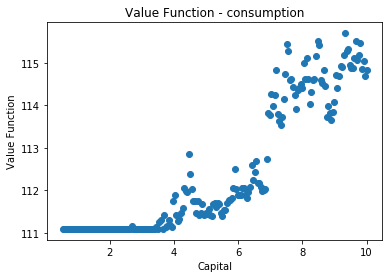

In [32]:
# Plot value function 
plt.figure()
# plt.plot(wvec, VF)
plt.scatter(k_grid[1:], VF[1:])
plt.xlabel('Capital')
plt.ylabel('Value Function')
plt.title('Value Function - consumption')
plt.show()

Now we plot the $\bf{policy}$ $\bf{function}$ for the choice of consumption:

<Figure size 432x288 with 0 Axes>

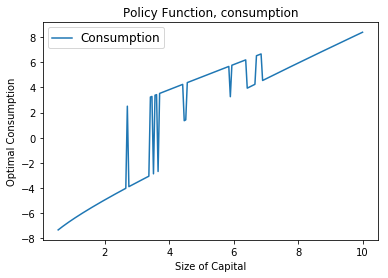

In [33]:
#Plot optimal consumption rule as a function of capital size
plt.figure()
fig, ax = plt.subplots()
ax.plot(k_grid[1:], optC[1:], label='Consumption')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper left', shadow=False)
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Capital')
plt.ylabel('Optimal Consumption')
plt.title('Policy Function, consumption')
plt.show()

Finally, we plot the $\bf{policy}$ $\bf{function}$ for the choice of capital next period:

<Figure size 432x288 with 0 Axes>

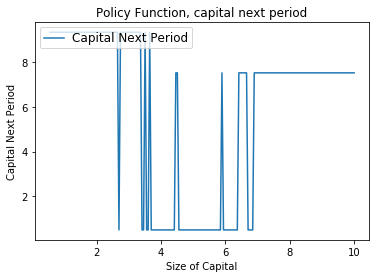

In [34]:
#Plot optimal consumption rule as a function of capital size
plt.figure()
fig, ax = plt.subplots()
ax.plot(k_grid[1:], optK[1:], label='Capital Next Period')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper left', shadow=False)
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Capital')
plt.ylabel('Capital Next Period')
plt.title('Policy Function, capital next period')
plt.show()

Finally, Let us now repeat this process for one more set of values of the productivity shock $v$. Here we will choose $0.5$.

In [35]:
'''
------------------------------------------------------------------------
Create grid of current utility values    
------------------------------------------------------------------------
C        = matrix, current consumption
I        = matrix, current investment
Z        = matrix, productivity shocks
U        = matrix, current period utility value for all possible
           choices of k and k' (rows are k, columns k')
------------------------------------------------------------------------
'''
C = np.zeros((size_k, size_k)) 
Y = np.zeros((size_k, size_k))
I = np.zeros((size_k, size_k))
Z = [0.5]

for i in range(size_k):
    Z.append(np.exp(rho * np.log(Z[i]) + np.random.normal(0,sigma_v)))
    
Z=np.array(Z)

print(Z)

for i in range(size_k): # loop over k
    for j in range(size_k): # loop over k'
        Y[i,j] = Z[i] * k_grid[i] ** alpha # production function = stoch shock * capital ^ alpha
        I[i,j] = k_grid[j] - (1-delta) * k_grid[i] # investment, determined by the k'=(1-delta)k+i law of motion
        C[i, j] = Y[i,j] - I[i,j] # resource constraint
        
# replace 0 and negative consumption with a tiny value 
# This is a way to impose non-negativity on cons
C[C<=0] = 1e-15
I[I<=0] = 1e-15
if gamma == 1:
    U = np.log(C)
else:
    U = (C ** (1-gamma)) / (1-gamma)
U[C<0] = -1e10

[0.5        0.65268506 0.77633022 0.82446971 0.83397983 0.76672058
 0.857096   0.95315323 0.83605226 0.60294495 0.85269194 1.04259891
 0.88593523 0.70793405 0.63804864 0.67539487 0.68718868 0.63302556
 0.7428862  0.6903394  0.6196295  0.73075354 0.58973006 0.65676472
 0.65853808 0.70031422 0.82522524 0.99270302 1.20172153 1.72188884
 1.30041714 1.61834097 1.95953047 1.46381399 1.8733549  1.54370829
 1.54390833 1.6389801  1.25689501 1.81644731 1.69676941 1.69147037
 1.27659269 1.13551139 0.8067223  0.83182676 1.01695384 0.8156523
 0.99711197 0.78199372 0.572289   0.67690704 0.57722067 0.66213086
 0.59740702 0.77261507 0.73613974 0.4858471  0.558191   0.50529337
 0.54641178 0.70741176 0.65100006 0.89721371 1.17976144 1.40573414
 1.3412947  1.69297674 1.03318987 0.96174877 1.09466365 1.47021524
 1.52730844 1.66121068 2.21764779 2.36867832 2.53366792 2.01118982
 1.96768018 1.70539922 1.33003597 1.35968574 1.32865265 1.29361709
 1.18805287 1.11141256 1.4359761  1.65485126 0.94124843 1.01405

Now, this next step is virtually the same as we covered in class, where I apply a Bellman equation $V_{T+1} = u(c) + V_{T}$ looped over multiple iterations, recalculation the value function many times and corresponding policy functions.

In [36]:
'''
------------------------------------------------------------------------
Value Function Iteration    
------------------------------------------------------------------------
VFtol     = scalar, tolerance required for value function to converge
VFdist    = scalar, distance between last two value functions
VFmaxiter = integer, maximum number of iterations for value function
V         = vector, the value functions at each iteration
Vmat      = matrix, the value for each possible combination of k and k'
Vstore    = matrix, stores V at each iteration 
VFiter    = integer, current iteration number
TV        = vector, the value function after applying the Bellman operator
PF        = vector, indicies of choices of k' for all k 
VF        = vector, the "true" value function
------------------------------------------------------------------------
'''
VFtol = 1e-8 
VFdist = 5.0 
VFmaxiter = 3000 
V = np.zeros(size_k) # initial guess at value function
Vmat = np.zeros((size_k, size_k)) # initialize Vmat matrix
Vstore = np.zeros((size_k, VFmaxiter)) #initialize Vstore array
VFiter = 1 
while VFdist > VFtol and VFiter < VFmaxiter:  
    for i in range(size_k): # loop over k
        for j in range(size_k): # loop over k'
            Vmat[i, j] = U[i, j] + beta * V[j] 
      
    Vstore[:, VFiter] = V.reshape(size_k,) # store value function at each iteration for graphing later
    TV = Vmat.max(1) # apply max operator to Vmat (to get V(k))
    PF = np.argmax(Vmat, axis=1)
    VFdist = (np.absolute(V - TV)).max()  # check distance
    V = TV
    VFiter += 1 
    


if VFiter < VFmaxiter:
    print('Value function converged after this many iterations:', VFiter)
else:
    print('Value function did not converge')            


VF = V # solution to the functional equation

Value function converged after this many iterations: 491


There were $\mathtt{489}$ iterations.

This next part involves using the formula for the choice of consumption based off capital, organized in the order of the $\mathtt{PF}$-selected values. I used the formula
$$
\mathtt{optC} = \mathtt{Z}_{\mathtt{PF}} \cdot \mathtt{k}\_\mathtt{grid} ^ \mathtt{alpha} - \left( \mathtt{optK} - (1-\mathtt{delta}) \cdot \mathtt{k}\_\mathtt{grid} \right),
$$
i.e.,
$$
c=z\cdot k^\alpha - (k^{\prime} - (1-\delta)\cdot k).
$$

In [37]:
'''
------------------------------------------------------------------------
Find consumption and savings policy functions   
------------------------------------------------------------------------
optK  = vector, the optimal choice of k' for each k
optC  = vector, the optimal choice of c' for each c
------------------------------------------------------------------------
'''
optK = k_grid[PF] # tomorrow's optimal capital size (savings function)
optC = Z[PF] * k_grid ** alpha - (optK - (1-delta) * k_grid) # optimal consumption, get consumption through the transition eqn

Plotting the $\bf{value}$ $\bf{function}$, we have:

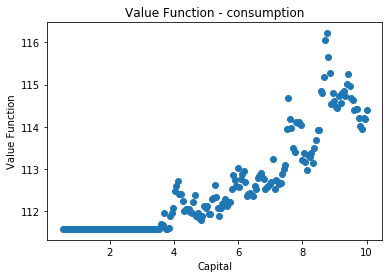

In [38]:
# Plot value function 
plt.figure()
# plt.plot(wvec, VF)
plt.scatter(k_grid[1:], VF[1:])
plt.xlabel('Capital')
plt.ylabel('Value Function')
plt.title('Value Function - consumption')
plt.show()

Now we plot the $\bf{policy}$ $\bf{function}$ for the choice of consumption:

<Figure size 432x288 with 0 Axes>

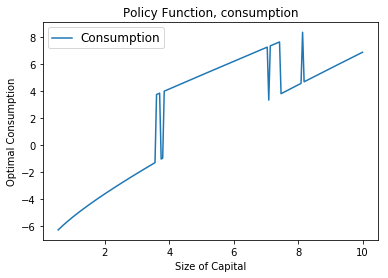

In [39]:
#Plot optimal consumption rule as a function of capital size
plt.figure()
fig, ax = plt.subplots()
ax.plot(k_grid[1:], optC[1:], label='Consumption')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper left', shadow=False)
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Capital')
plt.ylabel('Optimal Consumption')
plt.title('Policy Function, consumption')
plt.show()

Finally, we plot the $\bf{policy}$ $\bf{function}$ for the choice of capital next period:

<Figure size 432x288 with 0 Axes>

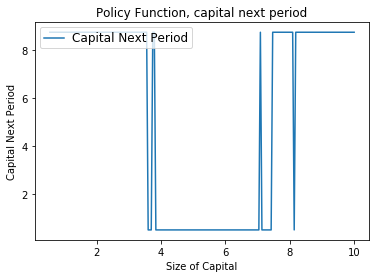

In [40]:
#Plot optimal consumption rule as a function of capital size
plt.figure()
fig, ax = plt.subplots()
ax.plot(k_grid[1:], optK[1:], label='Capital Next Period')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper left', shadow=False)
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Capital')
plt.ylabel('Capital Next Period')
plt.title('Policy Function, capital next period')
plt.show()